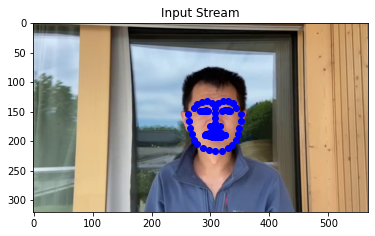

In [50]:
%pylab inline 


video_capture = cv2.VideoCapture("./test_face/003.mp4")

frame_count = 0

while video_capture.isOpened():    
    # Grab a single frame of video
    ret, frame = video_capture.read()

    # Bail out when the video file ends
    if not ret:
        video_capture.release()
        break
        
    # We will search face in every 15 frames to speed up process.
    frame_count += 1
    if frame_count % 10 == 0:    
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Display video frame
        title("Input Stream")
        plt.imshow(frame)        

        # Find all the faces and face encodings in the current frame of video
        rgb_frame = frame[:, :, ::-1]
        # face_locations = face_recognition.face_locations(rgb_frame)
        face_landmarks_list = face_recognition.face_landmarks(rgb_frame)
        
        # If faces were found, we will mark it on frame with blue dots
        if(len(face_landmarks_list)>0):
            keys = face_landmarks_list[0].keys()
            for k in keys:
                for face_location in face_landmarks_list[0][k]:        
                    plt.plot(face_location[0], face_location[1], 'bo')
                # plt.plot(face_location[1], face_location[2], 'bo')
                # plt.plot(face_location[3], face_location[2], 'bo')
                # plt.plot(face_location[3], face_location[0], 'bo')

            # Show frame...
            plt.show() 
            # ... and hold it until a new frame appears
            clear_output(wait=True)

In [50]:
# import imp
import face_recognition
import cv2
#import matplotlib.patches as patches
import matplotlib.pylab as plt
import numpy as np
# Loading video for face detection
#from numpy import size
import os
import imageio
from skimage.transform import resize
import pandas as pd
from skimage.draw import polygon2mask


def get_key_points(landmard):
    left_point = np.array(landmard['left_eye'])[
        np.argmax(np.array(landmard['left_eye']),axis=0)[0]]
    right_point = np.array(landmard['right_eye'])[
        np.argmin(np.array(landmard['right_eye']),axis=0)[0]]
    noise_down = np.array(landmard['nose_tip'])[
        np.argmax(np.array(landmard['nose_tip']),axis=0)[1]]
    noise_left_down = np.array(landmard['nose_tip'])[
        np.argmin(np.array(landmard['nose_tip']),axis=0)[0]]
    noise_right_down = np.array(landmard['nose_tip'])[
        np.argmax(np.array(landmard['nose_tip']),axis=0)[0]]
    points = np.array([left_point,right_point,noise_right_down,noise_down,noise_left_down,left_point])
    name = ["left_point","right_point","noise_right_down","noise_down","noise_left_down","left_point"]
    return points, name

def _get_value(mask):
    flatten = mask.flatten()
    value = flatten[flatten>0]
    return value
def describe_temperature(mask):
    value = _get_value(mask)
    return np.mean(value), np.max(value), np.min(value)


In [80]:
png_path = "./test_face/png/"
bmt_path = "./test_face/BMT1/"
heat_table = "./test_face/excel/"
path_list = os.listdir(png_path)
keys = ["nose_bridge", "nose_tip"]

In [96]:
with open('tf.transform') as f:
    tf = f.read()
tf = tf.split("\n")
center_x = int(tf[0])
center_y = int(tf[1])
size = float(tf[2])

In [97]:
size

4.19

In [98]:
i = 0
# center_x = 740
# center_y = 1060
# size = 4.19
im = imageio.imread(os.path.join(png_path, path_list[i]))
#bmt = imageio.imread(os.path.join(bmt_path, path_list[i][:-4]+'.BMT'))
bmt_3c = imageio.imread(os.path.join(bmt_path, path_list[i][:-4]+'.BMT'))
bmt = pd.read_excel(os.path.join(heat_table, path_list[i][:-4]+'.xlsx'),index_col=None, header=None ).values
face_landmarks_list = face_recognition.face_landmarks(np.array(im))
btm_resize = resize(bmt, (int(bmt.shape[0]*size),int(bmt.shape[1]*size)))

start_x = int(center_x-btm_resize.shape[0]/2)
end_x = int(center_x+btm_resize.shape[0]/2)
start_y = int((center_y-btm_resize.shape[1]/2))
end_y = int(center_y+btm_resize.shape[1]/2)

btm_pad = np.zeros(im.shape[0:2])
btm_pad[start_x:end_x, start_y:end_y] = btm_resize

print(bmt.shape)

(240, 320)


In [73]:
data = pd.DataFrame(index=np.arange(0,len(path_list)))
for i in range(0, len(path_list)):
    basename = os.path.basename(path_list[i])[:-4]
    im = imageio.imread(os.path.join(png_path, path_list[i]))
    #bmt = imageio.imread(os.path.join(bmt_path, path_list[i][:-4]+'.BMT'))
    bmt_3c = imageio.imread(os.path.join(bmt_path, path_list[i][:-4]+'.BMT'))
    bmt = pd.read_excel(os.path.join(heat_table, path_list[i][:-4]+'.xlsx'),index_col=None, header=None ).values
    face_landmarks_list = face_recognition.face_landmarks(np.array(im))
    btm_resize = resize(bmt, (int(bmt.shape[0]*size),int(bmt.shape[1]*size)))
    btm_pad = np.zeros(im.shape[0:2])

    # start_x = int(center_x-btm_resize.shape[0]/2)
    # end_x = int(center_x+btm_resize.shape[0]/2)
    # start_y = int((center_y-btm_resize.shape[1]/2))
    # end_y = int(center_y+btm_resize.shape[1]/2)

    btm_pad[start_x:end_x, start_y:end_y] = btm_resize
    mask = np.zeros(im.shape[0:2])
    data.loc[i,'name']=basename
    if(len(face_landmarks_list)>0):
        for p in range(0, len(face_landmarks_list)):
            points, name = get_key_points(face_landmarks_list[p])
            mask_p = polygon2mask(im.shape[0:2], points[:,[1,0]])
            tmp = np.mean(_get_value(mask_p*btm_pad))
            data.loc[i,p]=tmp

/Users/wlli/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wlli/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/wlli/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wlli/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [61]:
data

name          0          1   2
0  IR001723  33.135538  33.545521 NaN
1  IR001724  32.781643  32.045467 NaN
2  IR001727  31.843658  31.486360 NaN
3  IR001726  33.709042  31.422859 NaN
4  IR001772  32.211000        NaN NaN

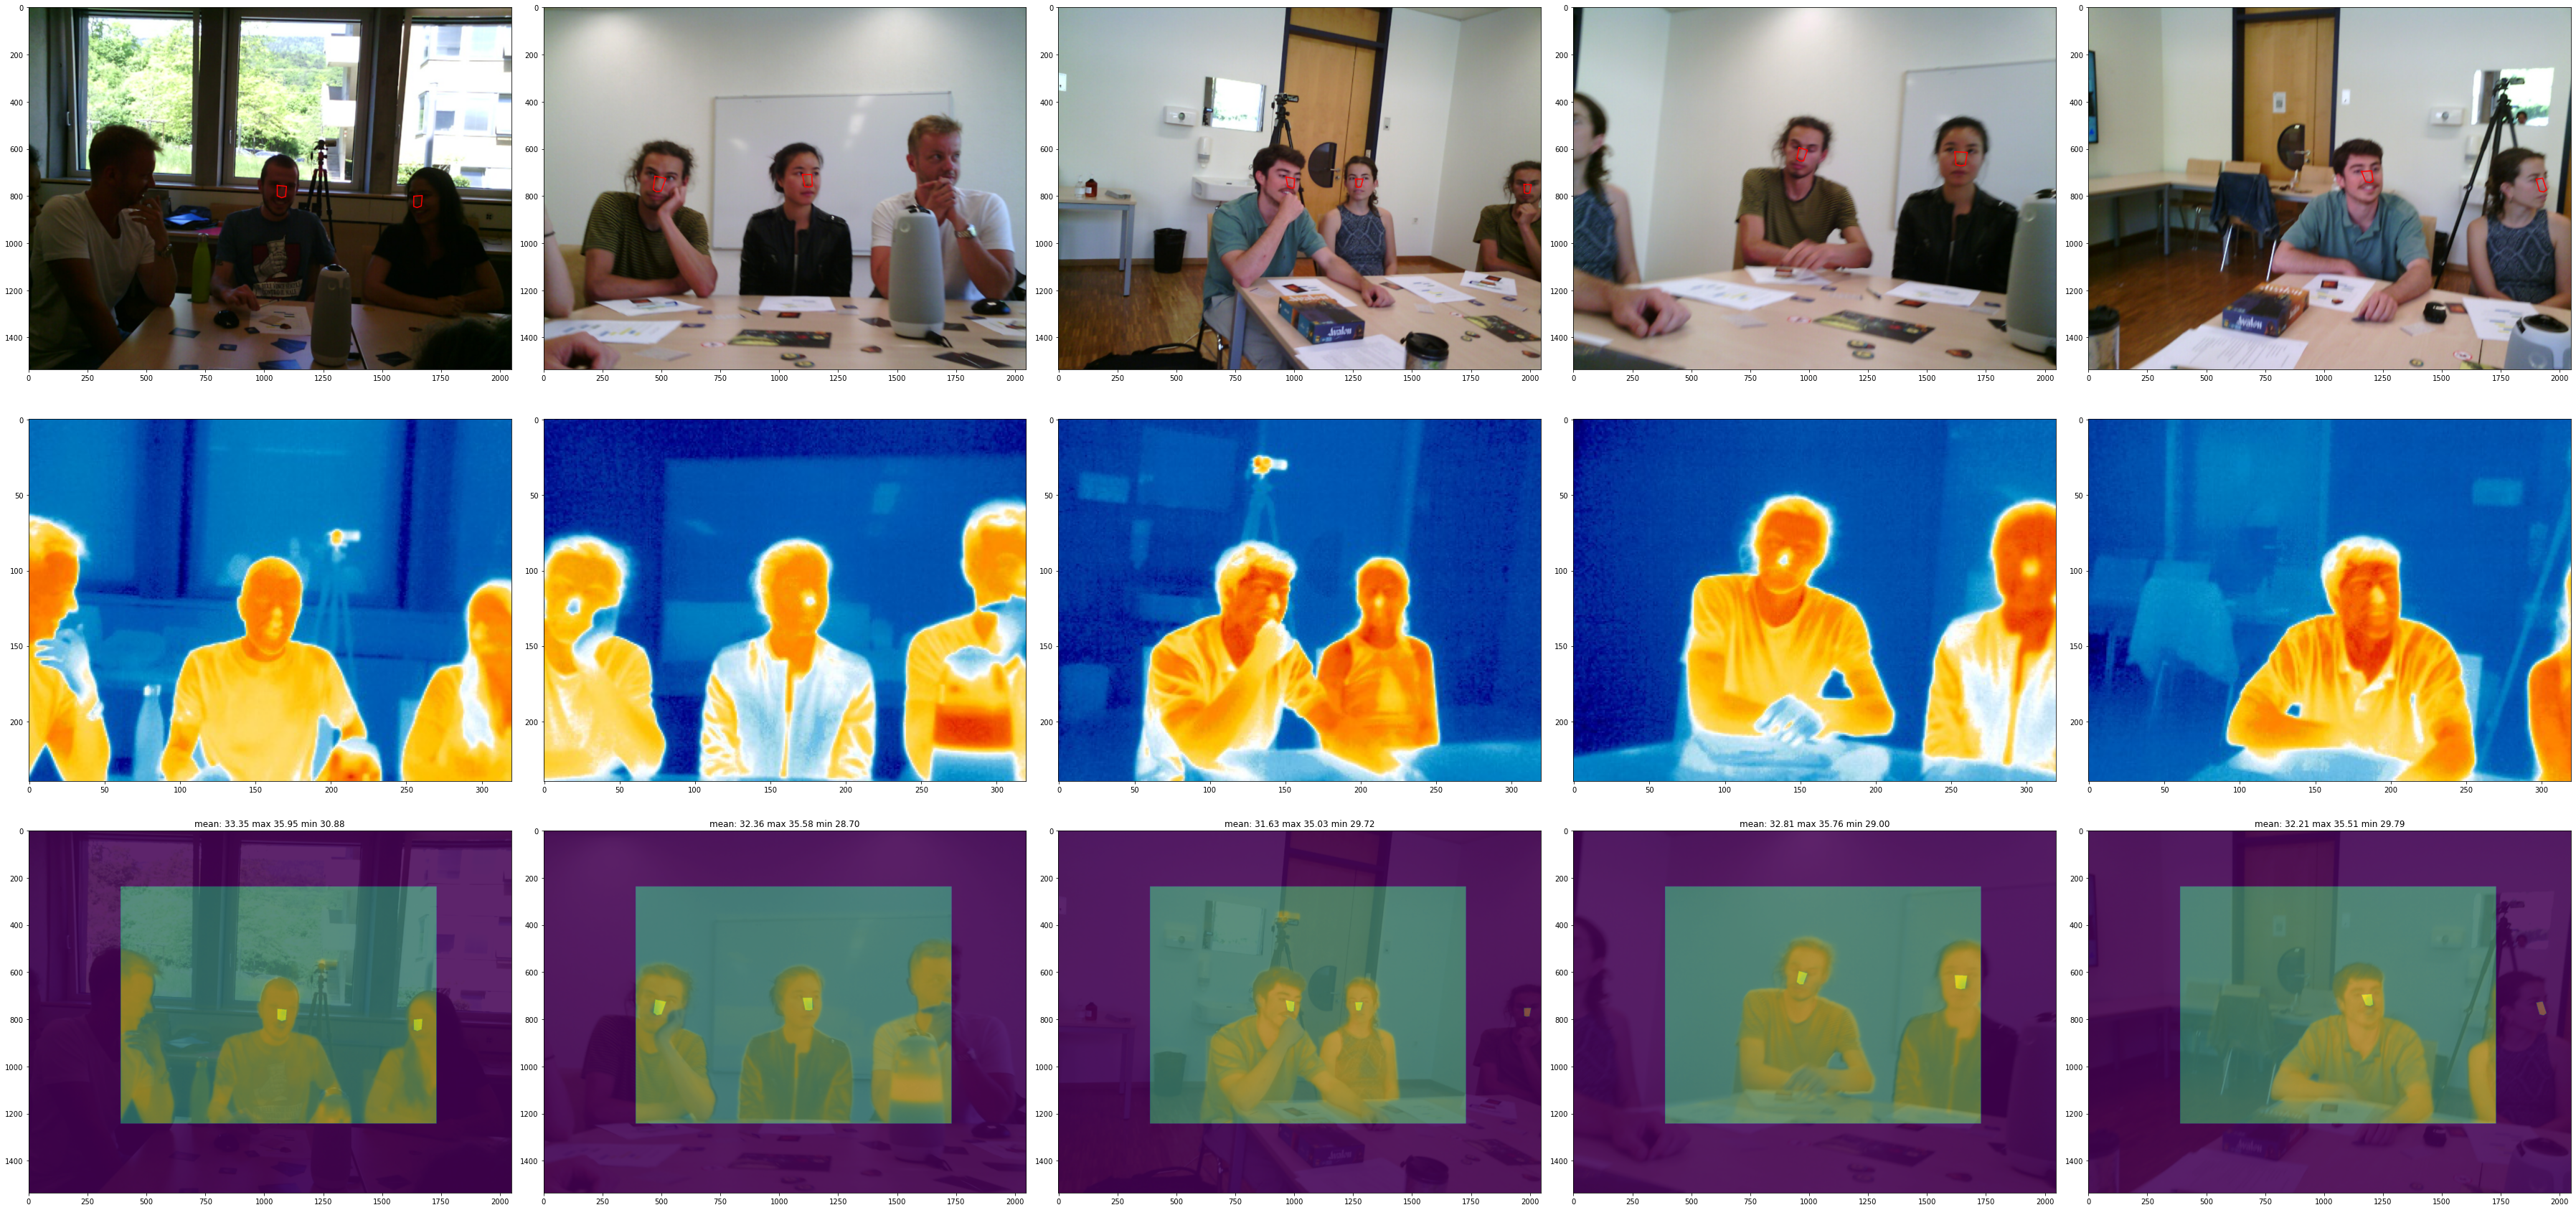

In [55]:
from pyparsing import alphas


fig, axs = plt.subplots(3, len(path_list), figsize=(10*len(path_list),8*3))
for i in range(0, len(path_list)):
    im = imageio.imread(os.path.join(png_path, path_list[i]))
    #bmt = imageio.imread(os.path.join(bmt_path, path_list[i][:-4]+'.BMT'))
    bmt_3c = imageio.imread(os.path.join(bmt_path, path_list[i][:-4]+'.BMT'))
    bmt = pd.read_excel(os.path.join(heat_table, path_list[i][:-4]+'.xlsx'),index_col=None, header=None ).values
    face_landmarks_list = face_recognition.face_landmarks(np.array(im))
    btm_resize = resize(bmt, (int(bmt.shape[0]*size),int(bmt.shape[1]*size)))
    btm_pad = np.zeros(im.shape[0:2])
    btm_pad[start_x:end_x, start_y:end_y] = btm_resize
    mask = np.zeros(im.shape[0:2])
    if(len(face_landmarks_list)>0):
        axs[0,i].imshow(im)
        axs[1,i].imshow(bmt_3c)
        axs[2,i].imshow(im)
        axs[2,i].imshow(btm_pad, alpha=0.8)
        for p in range(0, len(face_landmarks_list)):
            points, name = get_key_points(face_landmarks_list[p])
            axs[0,i].plot(points[:,0], points[:,1],'-',c='r')
            mask_p = polygon2mask(im.shape[0:2], points[:,[1,0]])
            mask = mask + mask_p
        axs[2,i].imshow(mask,alpha=0.3)
        values = describe_temperature(((mask>0) * btm_pad))
        axs[2,i].set_title((' ').join(["mean:",f"{values[0]:.2f}","max", f"{values[1]:.2f}", "min", f"{values[2]:.2f}"]))
plt.tight_layout()
plt.savefig("output_01.png", dpi=300)